<a href="https://colab.research.google.com/github/LinhartV/NTI/blob/main/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

Cilem Notebooku je seznameni s datsetem MNIST a vicevrstvym perceptronem (MLP).

Vasim ukolem je upravit Notebook tak, abyste dosahli co nejlepsi presnosti (accuracy) predikce na testovacim datasetu. Muzete vyzkouset napr. zmenu architektury site (vice vrstev, vice uzlu ve vrstvach, jine aktivacni funkce) nebo zmenu trenovani (zmena velikosti learning rate, velikosti batch_size nebo poctu epoch).

In [89]:
# import knihoven
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pro jednoduchost bude v tomto notebooku pouzita knihovna Keras, ktera bezi nad Tensorflow
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.utils import to_categorical, set_random_seed
from keras.optimizers import SGD

In [90]:
# zaseedovani pro reproducibilitu vypoctu https://keras.io/examples/keras_recipes/reproducibility_recipes/
set_random_seed(72)

MNIST je jeden ze znamych datasetu. Sklada se z obrazku rucne psanych cislic 0 az 9. Nasim ukolem je naucit neuronovou sit, ktera dokaze rozpoznat, jake cislo je na obrazku.

MNIST jde jednoduse [stahnout s pomoci Kerasu](https://keras.io/api/datasets/mnist/). Celkem se jedna o 60000 trenovacich a 10000 testovacich obrazku o rozmerech 28x28.

In [91]:
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

Vytiskneme si 100 cislic z trenovaci mnoziny

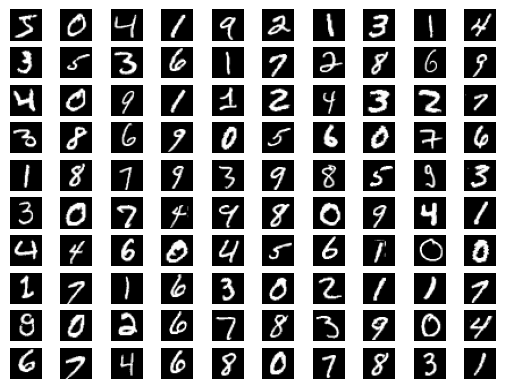

In [92]:
plt.figure()

for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.axis('off')
plt.show()

Pro kazdy obrazek zname spravny vystup. Prirazene labely jsou:

In [93]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Celkem mame 10 trid:

In [94]:
n_labels = len(np.unique(y_train))
n_labels

10

Labely tedy odpovidaji cislum na obrazcich, tedy se jedna o cisla 0 az 9. Pro klasifikaci vsak potrebujeme trochu jiny vystup. Provedeme tzv. one-hot encoding. Kazdy label bude reprezentovan vektorem delky D, kde D je pocet trid. Tento vektor bude mit vsude same 0 a jen pro spravnou tridu 1.

Napr. 5 bude v nasem pripade reprezentovana jako vektor [0,0,0,0,0,1,0,0,0,0]

In [95]:
y_train[0]

5

In [96]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [97]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

MLP ocekava na vstupu vektor. Obrazky cislic maji dva rozmery, a tak je musime prevest do tvaru vektoru.

In [98]:
x_train[0].shape

(28, 28)

In [99]:
x_size = x_train[0].shape[0] * x_train[0].shape[1]

x_train = x_train.reshape([-1, x_size])
x_test = x_test.reshape([-1, x_size])

In [100]:
x_train[0].shape

(784,)

Jednotlive hodnoty vektoru x_train jsou cela cisla v rozmezi 0-255, coz odpovida barve v odstinech sede. Budeme chtit hodnoty normalizovat.

In [101]:
np.min(x_train), np.max(x_train)

(0, 255)

In [102]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

In [103]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

Jako zaklad pro nas model poslouzi trida `Sequential`, do ktere budeme metodou `add` pridavat jednotlive vrstvy MLP. Vypocet se provadi "shora dolu".

Fully-connected vrstva je zde reprezentovana tridou `Dense`, ktere jako parametr predavame pocet uzlu ve vrstve. Podle [dokumentace](https://keras.io/api/layers/core_layers/dense/) nam trida `Dense` umoznuje pridat i [aktivacni funkci](https://keras.io/api/layers/activations/) pomoci parametru `activation`. Dale pak umoznuje pridat treba i regularizaci - napr:`kernel_regularizer=regularizers.L2(0.01)` (vice k regularizaci najdete [zde](https://keras.io/api/layers/regularizers/)).

Aktivacni funkci muzeme pridat take pomoci tridy `Activation`.

V neposledni rade musime definovat velikost vstupu `input_dim` (pouze v prvni vrstve a ostatni se dopoctou).

In [104]:
model = Sequential()
model.add(Dense(56, input_dim=x_size, activation="relu"))
model.add(Dense(n_labels))
model.add(Activation('softmax'))

In [105]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 56)                43960     
                                                                 
 dense_24 (Dense)            (None, 10)                570       
                                                                 
 activation_12 (Activation)  (None, 10)                0         
                                                                 
Total params: 44530 (173.95 KB)
Trainable params: 44530 (173.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Jak chceme model natrenovat definujeme metodou `compile`. Volime chybovou funkci `categorical_crossentropy`, k uceni modelu pouzijeme `sgd` a behem trenovani/testovani chceme pocitat presnost `accuracy`.

In [106]:
opt = SGD(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Natrenujeme model.

In [107]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8978 - accuracy: 0.4688 - val_loss: 1.4738 - val_accuracy: 0.6643
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 1.2132 - accuracy: 0.7209 - val_loss: 0.9683 - val_accuracy: 0.7883
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.8718 - accuracy: 0.7982 - val_loss: 0.7352 - val_accuracy: 0.8338
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7047 - accuracy: 0.8311 - val_loss: 0.6131 - val_accuracy: 0.8552
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6095 - accuracy: 0.8484 - val_loss: 0.5395 - val_accuracy: 0.8680
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5484 - accuracy: 0.8610 - val_loss: 0.4906 - val_accuracy: 0.8760
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5058 - accuracy: 0.8700 - val_loss: 0.4558 - val_accuracy:

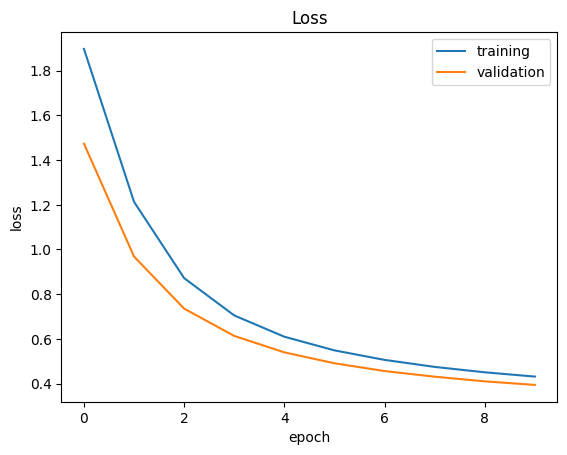

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

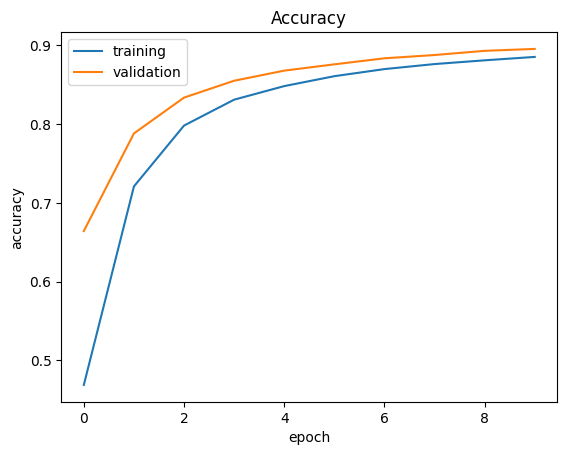

In [109]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

Vyhodnotime model na testovacim datatsetu. Chceme dosahnout presnosti minimalne 88.56%

In [110]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: %.2f" % (loss))
print("Test accuracy: %.2f%%" % (100.0 * acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.3978 - accuracy: 0.8961
Test loss: 0.40
Test accuracy: 89.61%
